In [123]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from pymongo import MongoClient

In [2]:
client = MongoClient(host='212.128.140.168',
                     port=27017,
                     username='superAdmin',
                     password='eurostarusal33')

In [3]:
database = client['sentiment']

In [4]:
collection = database['supervised_sentiment_tweets']

In [5]:
results = list()

for document in collection.find():
    obj = {
        'sentiment': document['sentiment'],
        'tweet': document['tweet']
    }
    
    results.append(obj)

In [6]:
import pandas as pd

In [7]:
df = pd.DataFrame(results)

In [8]:
df.head()

,sentiment,tweet
0,neutral,Pues bueno ya terminé la cosa esta
1,negative,Atención SUBNORMAL RETRATADA.
2,negative,De verdad que si esto es una broma puto paradl...
3,neutral,Nuestro Menú Especial disponible tiene esta ca...
4,positive,Ayyyy que monerías de sandalias es parteras am...


In [9]:
df['tweet_length'] = df['tweet'].str.len()

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

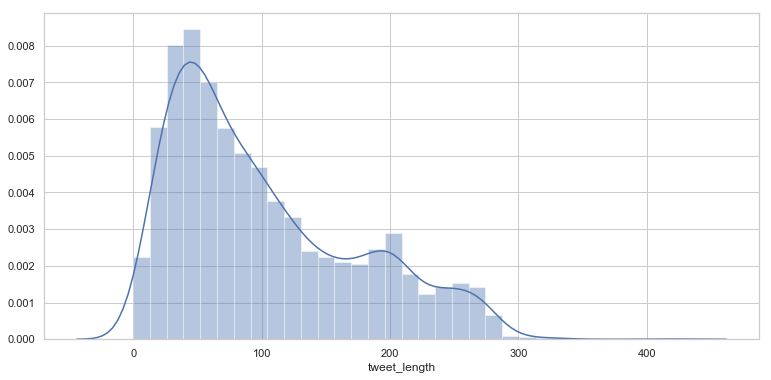

In [11]:
plt.figure(figsize=(12.8,6))

sns.distplot(df['tweet_length'])

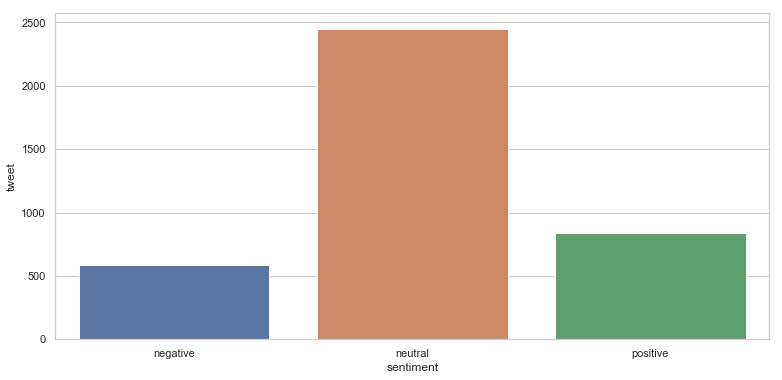

In [12]:
plt.figure(figsize=(12.8,6))

aux = df.groupby('sentiment').count()

sns.barplot(data=aux, x=aux.index, y='tweet')

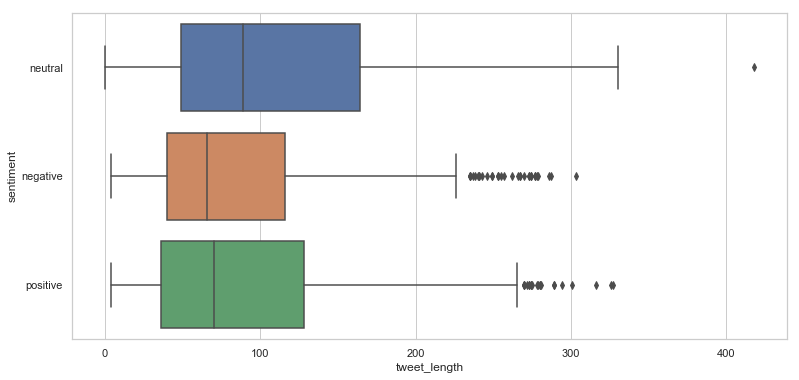

In [13]:
plt.figure(figsize=(12.8,6))

sns.boxplot(data=df, x='tweet_length', y='sentiment')

In [14]:
def get_stopwords():
    stopwords_list = list()

    with open('resources/stopwords-es.txt', 'rt', encoding='utf-8') as stopwords:
        for stopword in stopwords.readlines():
            stopwords_list.append(stopword.strip())

        stopwords.close()
        
    return stopwords_list

In [22]:
import re

In [23]:
def tokenizer(tweet, stopwords_list):
    url_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    html_pattern = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    spaces_pattern = re.compile('[ ]{2,}')
    
    result = url_pattern.sub('', tweet)
    result = html_pattern.sub('', result)
    result = spaces_pattern.sub('', result)
    result = re.findall('\w+', result)
    
    result = ' '.join([word.lower() for word in result if word.lower() not in stopwords_list])
    
    return result

In [24]:
stopwords_list = get_stopwords()

In [25]:
results = [tokenizer(tweet, stopwords_list) for tweet in df['tweet']]

In [26]:
df['tokenized'] = results

In [27]:
df

,sentiment,tweet,tweet_length,tokenized
0,neutral,Pues bueno ya terminé la cosa esta,34,terminé cosa
1,negative,Atención SUBNORMAL RETRATADA.,29,atención subnormal retratada
2,negative,De verdad que si esto es una broma puto paradl...,70,broma puto paradla gracia
3,neutral,Nuestro Menú Especial disponible tiene esta ca...,184,menú especial disponible cara apetecible comid...
4,positive,Ayyyy que monerías de sandalias es parteras am...,137,ayyyy monerías sandalias parteras amores llega...
...,...,...,...,...
3865,negative,"Sanemci que Can también ha sufrido, irse y dej...",82,sanemci can sufrido irse dejarte duro nuevoser...
3866,negative,"Señor Escolar, no tiene algún artículo más nue...",90,señor escolar artículo limpie culo
3867,negative,ACEPTO EL RETO de este experimento social llam...,219,acepto reto experimento social llamadoquiero h...
3868,negative,He visto como una chica se fumaba el cigarrill...,127,visto chica fumaba cigarrillo orilla tirado ma...


In [28]:
df[df['sentiment'] == 'negative']['tokenized'].tolist()[:2]

['atención subnormal retratada', 'broma puto paradla gracia']

In [29]:
for sentiment in ['negative', 'neutral', 'positive']:
    print([word for word in df[df['sentiment'] == sentiment]['tokenized'].tolist()[:2]])

['atención subnormal retratada', 'broma puto paradla gracia']
['terminé cosa', 'menú especial disponible cara apetecible comidas martes domingo cenas viernes sabados víspera festivos colladovillalba madrid spain']
['ayyyy monerías sandalias parteras amores llegaron tiendas web feliz sandalias', 'pug felipe interrumpa beso forma jej']


In [30]:
sentiment_codes = {
    'negative': -1,
    'neutral': 0,
    'positive': 1,
}

In [31]:
df['sentiment_code'] = df['sentiment']
df = df.replace({'sentiment_code': sentiment_codes})

In [32]:
negative = df[df['sentiment'] == 'negative']

In [33]:
neutral = df[df['sentiment'] == 'neutral']

In [34]:
positive = df[df['sentiment'] == 'positive']

In [35]:
train = pd.concat([negative, neutral, positive], ignore_index=True)

In [36]:
from sklearn.utils import shuffle

In [37]:
train = shuffle(train)

In [77]:
train.reset_index(drop=True, inplace=True)

In [78]:
import pickle

In [79]:
with open('sentiment.pickle', 'wb') as pico:
    pickle.dump(train, pico)

In [80]:
with open('sentiment.pickle', 'rb') as pico:
    caca = pickle.load(pico)

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(train['tokenized'],
                                                    train['sentiment_code'],
                                                    test_size=0.10, 
                                                    random_state=8)

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        max_features=10000,
                        norm='l2',
                        sublinear_tf=True)

In [43]:
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train

In [44]:
features_test = tfidf.transform(X_test).toarray()
labels_test = y_test

In [45]:
from sklearn.feature_selection import chi2
import numpy as np

In [46]:
for sentiment, sentiment_id in sorted(sentiment_codes.items()):
    features_chi2 = chi2(features_train, labels_train == sentiment_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    print("# '{}' category:".format(sentiment))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("")

# 'negative' category:
  . Most correlated unigrams:
. triste
. heterótrofa
. odio
. puta
. mierda

# 'neutral' category:
  . Most correlated unigrams:
. amo
. gracias
. feliz
. puta
. mierda

# 'positive' category:
  . Most correlated unigrams:
. bonito
. amo
. enhorabuena
. feliz
. gracias



In [47]:
from sklearn.neighbors import KNeighborsClassifier

In [48]:
knn = KNeighborsClassifier()

In [49]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [50]:
params = {
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [15, 30, 45],
    'n_neighbors': [5, 10, 25, 50, 100],
}

In [53]:
# from sklearn.model_selection import GridSearchCV

In [52]:
# gridsearch = GridSearchCV(estimator=knn, param_grid=params, cv=5, n_jobs=1)

In [284]:
# gridsearch.fit(features_train, labels_train)

In [285]:
# gridsearch.best_params_

In [286]:
# gridsearch.cv_results_['mean_test_score']

In [287]:
knn.fit(features_train, labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [288]:
pred = knn.predict(features_test)

In [289]:
pred

array([ 0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,
       -1,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1, -1, -1,
        0,  0,  0,  0, -1, -1,  0, -1,  0,  0,  0,  0,  0, -1,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1,  0,  0,  0,  0, -1, -1,
        0,  0,  0, -1, -1,  0,  0,  0,  0, -1,  0,  0, -1,  0, -1, -1,  0,
        0,  0, -1,  0,  0,  0,  0, -1,  0, -1,  0, -1,  0, -1, -1,  0, -1,
       -1, -1,  0,  0, -1,  0,  0,  0, -1, -1,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1, -1,  0,
        0,  1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0, -1,  0,
        0, -1,  0,  0,  0,  0, -1,  0, -1,  0, -1, -1, -1,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0, -1, -1,  0, -1,  0, -1,  0, -1, -1,  0,  0,
       -1,  1,  0,  0,  0

In [65]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(labels_train, knn.predict(features_train))

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
forest = RandomForestClassifier()

In [56]:
forest.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

In [58]:
countvec = CountVectorizer(analyzer = "word")

In [59]:
countvec_train = countvec.fit_transform(X_train)

In [60]:
countvec_test = countvec.transform(X_test)

In [61]:
forest.fit(countvec_train, y_train)

c:\users\usal\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [62]:
pred = forest.predict(countvec_test)

In [66]:
accuracy_score(pred, y_test)

0.6227390180878553

In [67]:
vectorizer = CountVectorizer(strip_accents='unicode',
                             lowercase=True,
                             analyzer='word')

In [68]:
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

---
# aaaaa

In [129]:
from sklearn.naive_bayes import MultinomialNB

In [130]:
multinb = MultinomialNB()

In [131]:
multinb.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [132]:
import numpy as np

In [133]:
params = {
    'alpha': [round(value, 1) for value in np.arange(0, 1, .1)],
    'fit_prior': [True, False]
}

In [120]:
from sklearn.model_selection import GridSearchCV

In [134]:
gridsearch = GridSearchCV(estimator=multinb, param_grid=params, cv=5, n_jobs=1)

In [135]:
gridsearch.fit(features_train, labels_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [136]:
gridsearch.best_params_

{'alpha': 0.5, 'fit_prior': True}

In [137]:
gridsearch.cv_results_['mean_test_score']

array([0.57393052, 0.55612977, 0.5601493 , 0.4039621 , 0.60465116,
       0.4137238 , 0.62360034, 0.42492105, 0.64025266, 0.43870227,
       0.64685616, 0.44932529, 0.64341085, 0.4559288 , 0.64053976,
       0.46482917, 0.63853   , 0.472294  , 0.63824289, 0.47918461])

---
# bbbbbbb

In [138]:
from sklearn.ensemble import RandomForestClassifier

In [139]:
forest = RandomForestClassifier()

In [140]:
forest.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [159]:
params = {
    'bootstrap': [True],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [100],
}

In [160]:
from sklearn.model_selection import GridSearchCV

In [161]:
gridsearch = GridSearchCV(estimator=forest, param_grid=params, cv=5, n_jobs=1)

In [162]:
gridsearch.fit(features_train, labels_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [163]:
gridsearch.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_features': 'sqrt',
 'n_estimators': 100}

In [164]:
gridsearch.cv_results_['mean_test_score']

array([0.65575653, 0.65518231, 0.65518231, 0.65403388, 0.65747918,
       0.65747918])

---
# ccccc

In [ ]:
classifiers = [
    RandomForestClassifier(),
    GaussianNB(),
    MultinomialNB()
]

In [126]:
multinb = MultinomialNB(alpha=.5, fit_prior=True)
multinb.fit(features_train, labels_train)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [127]:
y_predicted = multinb.predict(features_test)

In [121]:
gridsearch = GridSearchCV(estimator=multinb, param_grid=params, cv=5, n_jobs=1)

In [122]:
gridsearch.fit(features_train, labels_train)

c:\users\usal\appdata\local\programs\python\python37\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
c:\users\usal\appdata\local\programs\python\python37\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
c:\users\usal\appdata\local\programs\python\python37\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
c:\users\usal\appdata\local\programs\python\python37\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
c:\users\usal\appdata\local\programs\python\python37\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [124]:
gridsearch.best_params_

{'alpha': 0.5, 'fit_prior': True}

In [125]:
gridsearch.cv_results_['mean_test_score']

array([0.57393052, 0.55612977, 0.5601493 , 0.4039621 , 0.60465116,
       0.4137238 , 0.62360034, 0.42492105, 0.64025266, 0.43870227,
       0.64685616, 0.44932529, 0.64341085, 0.4559288 , 0.64053976,
       0.46482917, 0.63853   , 0.472294  , 0.63824289, 0.47918461])

In [128]:
multinb.score(features_test, labels_test)

0.6434108527131783